<a href="https://colab.research.google.com/github/daldric/MNIST-Machine-Learning/blob/main/MNIST_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Ingestion -> Model -> Output -> update model -> ?

Step 1 - import the needed libraries
Step 2 - load the data
Step 3 - visualize the data
Step 4 - data preprocessing and data augmentation
Step 5 - define the model
Step 6 - evaluating the result

In [ ]:
# Step 1 - import the needed libraries
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
import torch.nn.functional as F
import statistics
from torch.utils.data import TensorDataset, DataLoader, random_split
from utils import read_data
import torch.optim as optim
import math
import PIL
from PIL import Image
from google.colab import files
import cv2

Saving seven.png to seven.png
Saving three.png to three.png


(-0.5, 27.5, 27.5, -0.5)

<Figure size 432x288 with 0 Axes>

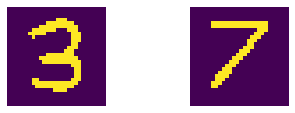

In [ ]:
# importing my images, adding them to a 2d list with their labels
uploaded = files.upload()
myImages = []
img = cv2.imread('three.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('seven.png', cv2.IMREAD_GRAYSCALE)
img = cv2.bitwise_not(img)
img = img.astype(float)
img2 = cv2.bitwise_not(img2)
img2 = img2.astype(float)
myImages.append([img, 0])
myImages.append([img2, 1])
plt.clf()
fig=plt.figure()
fig.add_subplot(2, 2, 1)
plt.imshow(img)
plt.axis('off')
fig.add_subplot(2, 2, 2)
plt.imshow(img2)
plt.axis('off')

In [ ]:
print(img.shape)
myImages = [[img, 0], [img2, 1]]
print(len(myImages[0][0]))
for x in range(len(myImages)):
  for row in range(len(myImages[x][0])):
    for col in range(len(myImages[x][0][row])):
      if myImages[x][0][row][col] == 255:
        myImages[x][0][row][col] = 1
      # print(myImages[x][0][row][col].item())
  myImages[x][0] = torch.tensor(myImages[x][0])
  myImages[x][0] = myImages[x][0].squeeze(0)
  myImages[x][0] = myImages[x][0].unsqueeze(0)
  
      

print(type(myImages[0][0][0][0][0].item())) # needs to be type float, not byte (or int, whatever)
print(myImages[0][0].shape)


(28, 28)
28
<class 'float'>
torch.Size([1, 28, 28])


In [ ]:
# custom datasets so that the indices can be reassigned to make the loader binary
class Training(Dataset):
  
  def __init__(self):
    self.data=[]
    training = torchvision.datasets.MNIST(root="./", train=True, download=True, transform=ToTensor())
    test = False
    for x in range(len(training)):
      if training[x][1]==3:
        l=list(training[x])
        l[1]=0
        l=tuple(l)
        self.data.append(l)
        if test:
          print(l)
          test=False
      elif training[x][1]==7:
        l=list(training[x])
        l[1]=1
        l=tuple(l)
        self.data.append(l)
      '''
      else:
        l=list(training[x])
        l[1]=2
        l=tuple(l)
        self.data.append(l)
      '''
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]
  

class Testing(Dataset):
  
  def __init__(self):
    self.data=[]
    testing = torchvision.datasets.MNIST(root="./", train=False, download=True, transform=ToTensor())
    test = False
    for x in range(len(testing)):
      if testing[x][1]==3:
        l=list(testing[x])
        l[1]=0
        l=tuple(l)
        self.data.append(l)
        if test:
          print(l)
          test=False
      elif testing[x][1]==7:
        l=list(testing[x])
        l[1]=1
        l=tuple(l)
        self.data.append(l)
      '''
      else:
        l=list(testing[x])
        l[1]=2
        l=tuple(l)
        self.data.append(l)
      '''
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx]

class Custom(Dataset):

  def __init__(self):
    self.data=[]
    for i in range(len(myImages)):
      l=myImages[i]
      l=tuple(l)
      self.data.append(l)


  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
training_data = Training()

testing_data = Testing()

custom_data = Custom()

In [ ]:
# not needed to update all the information
print(len(training_data))
print(training_data[0][1])
image = training_data[0][0].numpy()
image = image.squeeze()
imgplot = plt.imshow(image)

print(len(testing_data))
print(testing_data[0][1])
print(testing_data[0][0].shape)
print(testing_data[0][0])
print(type(testing_data[0][0][0][0][0].item()))

In [ ]:
# not needed to update the information
# normalize the data with the mean and std
std = 0
sum = 0
divisor = 0
mean = 0
for x in range(len(training_data)):
  mean += training_data[x][0].mean().item()
mean = mean / len(training_data)

for x in range(len(training_data)):
  a = training_data[x][0].numpy()
  for y in range(28):
    for z in range(28):
      sum += math.pow(a[0][y][z] - mean, 2)
      divisor+=1

std = math.sqrt(sum / divisor)


print(mean) # mean is 0.1279 when binary, 0.1307 when using the whole dataset
print(std) # std is 0.3052 when binary, 0.3081 when using the whole dataset

In [ ]:
# not needed to update the information
# the mean and std of the custom dataset
std = 0
sum = 0
divisor = 0
mean = 0
for x in range(len(custom_data)):
  mean += custom_data[x][0].mean().item()
mean = mean / len(custom_data)

for x in range(len(custom_data)):
  a = custom_data[x][0].numpy()
  for y in range(28):
    for z in range(28):
      sum += math.pow(a[0][y][z] - mean, 2)
      divisor+=1

std = math.sqrt(sum / divisor)


print(mean) # mean is 0.1441
print(std) # std is 0.3512

0.14413265306122447
0.351224189632144


In [ ]:
data_transforms = transforms.Normalize(0.1279, 0.3052)
custom_transforms = transforms.Normalize(0.1441, 0.3512)
training_data.transform = data_transforms
testing_data.transform = data_transforms
custom_data.transform = custom_transforms

In [ ]:
# make the data loaders
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing_data, batch_size=64, shuffle=True)
custom_loader = DataLoader(custom_data, batch_size=len(custom_data), shuffle=False)

In [ ]:
# create a method to find the max indices of the tensor outputs
def batch_correct_num(data, values):
  num_correct = 0
  for x in range(len(values)):
    if torch.argmax(data, dim=1)[x]==values[x].item():
      num_correct+=1
  return num_correct

In [ ]:
# Now make the model as a class
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.layers = nn.Sequential(
      nn.Linear(784, 128), # input is the dimension of the image
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 2) # will eventually be three outputs, 0 is 3, 1 is 7, 2 is neither
    )
    
  def forward(self, data):
    x = data.view(data.size(0), -1) # 64 x 784
    output = self.layers(x)
    return output

n = Network()
print(n)

Network(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
)


In [ ]:
# Pass training data into the model
optimizer = optim.Adam(n.parameters(), lr=1e-5) # learning rate is hyperparameter that should be played with
EPOCHS = 10 # each epoch is a pass through all the data
loss_func = nn.CrossEntropyLoss()
loss_graphing = []
accuracy_graphing = []
test = False
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for epoch in range(EPOCHS):
  epoch_loss = 0
  num_correct = 0
  for data_X, data_y in training_loader:
    optimizer.zero_grad()
    output = n(data_X)
    loss = loss_func(output, data_y)
    loss.backward()
    optimizer.step()
    print(loss)
    epoch_loss += loss.item()
    num_correct += batch_correct_num(output, data_y)
    if test:
      print(output.shape)
      print(data_y)
      print(data_y.shape)
      print(output)
      print(len(output))
      print(predictions)
      print(len(predictions))
      test = False
    
  print("Epoch {}: Training Loss: {:.5f} Accuracy: {}/{}".format(epoch+1, epoch_loss, num_correct, len(training_data)))
  loss_graphing.append(epoch_loss)
  accuracy_graphing.append(num_correct)


tensor(0.7022, grad_fn=<NllLossBackward>)
tensor(0.7077, grad_fn=<NllLossBackward>)
tensor(0.6920, grad_fn=<NllLossBackward>)
tensor(0.6903, grad_fn=<NllLossBackward>)
tensor(0.6789, grad_fn=<NllLossBackward>)
tensor(0.6817, grad_fn=<NllLossBackward>)
tensor(0.6903, grad_fn=<NllLossBackward>)
tensor(0.6974, grad_fn=<NllLossBackward>)
tensor(0.7026, grad_fn=<NllLossBackward>)
tensor(0.6952, grad_fn=<NllLossBackward>)
tensor(0.7005, grad_fn=<NllLossBackward>)
tensor(0.6902, grad_fn=<NllLossBackward>)
tensor(0.6969, grad_fn=<NllLossBackward>)
tensor(0.6997, grad_fn=<NllLossBackward>)
tensor(0.6965, grad_fn=<NllLossBackward>)
tensor(0.7014, grad_fn=<NllLossBackward>)
tensor(0.6936, grad_fn=<NllLossBackward>)
tensor(0.7030, grad_fn=<NllLossBackward>)
tensor(0.7033, grad_fn=<NllLossBackward>)
tensor(0.6809, grad_fn=<NllLossBackward>)
tensor(0.6909, grad_fn=<NllLossBackward>)
tensor(0.6910, grad_fn=<NllLossBackward>)
tensor(0.6910, grad_fn=<NllLossBackward>)
tensor(0.6926, grad_fn=<NllLossBac

tensor([ 2.1582, -3.0992], grad_fn=<SelectBackward>)
tensor([ 1.4554, -2.0084], grad_fn=<SelectBackward>)
Accuracy: 1/2


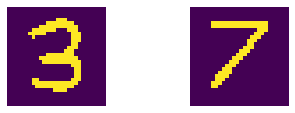

In [ ]:
# try the model on the cutom data
fig=plt.figure()
num_correct=0
for data_X, data_y in custom_loader:
  output = n(data_X.float())
  num_correct += batch_correct_num(output, data_y)
  for x in range(len(output)):
    print(output[x])
    fig.add_subplot(2, 2, x+1)
    plt.imshow(myImages[x][0][0])
    plt.axis('off')
print('Accuracy: {}/{}'.format(num_correct, len(custom_data)))


In [ ]:
# try the model on the testing data
num_correct=0
for data_X, data_y in testing_loader:
  output = n(data_X.float())
  num_correct += batch_correct_num(output, data_y)
  print(output)
print('Testing accuracy: {}/{}'.format(num_correct, len(testing_data)))

tensor([[-11.0073,  -3.8187],
        [-10.6239,  -4.9528],
        [-12.5406,  -2.7550],
        [ -4.0037, -14.5596],
        [ -4.2084, -13.8600],
        [-10.1643,  -4.3996],
        [-10.4995,  -4.2932],
        [ -9.3628,  -5.7924],
        [-12.6099,  -2.7596],
        [ -4.1987, -13.8179],
        [-10.3362,  -4.7342],
        [ -4.0882, -14.1646],
        [ -3.8805, -14.5642],
        [ -3.6881, -15.0631],
        [-10.7342,  -3.9824],
        [-11.3041,  -3.8906],
        [-10.5947,  -4.2073],
        [ -1.7664, -19.3474],
        [ -4.3053, -13.8104],
        [-11.6859,  -3.4008],
        [-10.1492,  -4.3488],
        [-13.0135,  -2.3894],
        [ -3.8831, -14.8068],
        [ -4.7688, -14.5005],
        [ -3.8230, -14.7516],
        [ -2.6532, -17.2561],
        [-11.1238,  -4.8480],
        [ -5.5597, -11.0020],
        [-12.7448,  -2.6010],
        [-11.4354,  -3.5748],
        [ -2.3892, -17.9057],
        [-12.0575,  -3.0870],
        [ -4.7313, -12.8156],
        [-

In [ ]:
# not needed to update the data
# visualize the results
fig=plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(epochs, height=accuracy_graphing)
ax.set_ylabel('Number Correct')
ax.set_xlabel('Epoch')
ax.set_title('Binary accuracy by epoch with training')
ax.set_yticks(np.arange(0, 13001, 1000))
plt.show()